# **Layer 07**

## **Prepare Environment**

### Import libraries and modules



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score

### Load the dataset
*   Training Data
*   Validation Data
*   Test Data

In [2]:
train_path = './../data/layer 7/layer_7_train.csv'
valid_path = './../data/layer 7/layer_7_valid.csv'
test_path = './../data/layer 7/layer_7_test.csv'

train_data = pd.read_csv(train_path)

valid_data = pd.read_csv(valid_path)

test_data = pd.read_csv(test_path)

### Dataset Info and split dataset according to the labels

In [21]:
print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

(28520, 772)
(750, 772)
(744, 769)


In [22]:
train_data.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768,label_1,label_2,label_3,label_4
0,0.186257,-0.058807,0.024632,-0.163933,-0.146699,0.035889,0.111708,-0.162861,0.028249,-0.098063,...,0.055629,-0.010358,0.125754,0.011648,0.079197,0.093215,45,NaN,1,6
1,0.063431,-0.023597,0.068057,-0.252915,-0.061094,-0.027316,0.135747,-0.168147,0.091236,-0.078473,...,-0.014893,0.071721,0.018918,0.100032,-0.083042,0.088615,45,NaN,1,6
2,0.034962,0.035816,-0.029753,-0.094607,-0.017576,-0.053074,0.040121,-0.007932,0.097872,-0.024042,...,0.012415,0.015215,0.083808,0.031312,-0.056277,0.064702,45,NaN,1,6
3,0.033772,0.085612,0.067488,-0.073953,-0.180646,-0.024512,0.242879,-0.023374,-0.059999,0.002006,...,-0.078246,-0.032903,0.082949,-0.020659,0.082274,-0.050164,45,NaN,1,6
4,0.134305,0.062096,0.106920,-0.089327,0.117093,-0.077107,0.152579,0.047529,-0.015998,-0.110657,...,-0.094629,0.069718,0.014379,0.048124,0.007586,-0.016980,45,NaN,1,6


In [23]:
valid_data.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768,label_1,label_2,label_3,label_4
0,0.085129,0.000378,-0.029872,-0.104609,-0.191291,-0.025511,0.029381,0.006177,0.079207,-0.012729,...,-0.026701,0.003306,0.052219,0.000784,0.004527,0.102033,45,NaN,1,6
1,0.222652,-0.094210,-0.056387,-0.210214,-0.294624,-0.032355,-0.069078,-0.172146,0.056509,-0.126757,...,-0.041096,0.013654,0.142623,-0.011882,0.005219,0.143616,45,NaN,1,6
2,0.072147,0.023575,-0.017664,-0.070988,-0.098729,0.018534,0.028282,-0.064789,0.094686,-0.067313,...,-0.064602,-0.018653,0.013636,-0.078994,0.060903,0.064752,45,NaN,1,6
3,0.026623,0.052005,-0.006921,-0.075105,-0.074829,-0.031380,0.012402,-0.043555,0.073825,-0.050979,...,-0.005655,0.015477,0.064209,0.025045,-0.049599,0.078412,45,NaN,1,6
4,0.112069,0.113702,0.044343,0.010162,-0.169193,-0.099847,0.195957,0.051861,0.024582,0.001314,...,-0.118097,-0.043349,0.036754,-0.023065,0.007358,-0.132566,45,NaN,1,6


In [24]:
test_data.head()

,ID,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768
0,1,0.187868,-0.009268,0.039846,-0.102515,-0.109121,-0.079769,0.061295,-0.042890,0.099860,...,0.043647,0.061174,0.026771,-0.092734,-0.052383,-0.055526,0.029101,0.041857,-0.027872,0.099500
1,2,0.122119,0.019015,0.134483,0.007949,-0.157884,-0.033332,0.044334,-0.016869,-0.014088,...,-0.179798,-0.027611,0.240023,-0.005648,-0.057537,0.023922,-0.038126,-0.015171,-0.006270,-0.003790
2,3,0.079187,0.146195,-0.001316,-0.085596,-0.261093,-0.021620,0.268898,-0.103950,0.068976,...,-0.075460,0.037346,0.124254,-0.369695,-0.056773,-0.028471,0.019971,-0.065683,-0.047366,-0.121744
3,4,0.231196,0.021558,0.215534,-0.210258,-0.158189,0.041621,0.240254,-0.068112,-0.017550,...,0.083334,0.141642,-0.007219,0.031547,-0.010762,-0.169036,-0.030963,0.086698,0.114194,-0.036775
4,5,0.020412,0.063732,-0.065506,-0.089598,-0.130788,-0.018809,0.119304,-0.057494,0.094714,...,-0.001969,-0.003025,-0.021156,-0.136993,-0.003615,0.036371,0.048715,-0.002688,-0.016957,-0.004331


Drop the ID column from the test dataset

In [25]:
test_IDs = test_data['ID'].to_numpy()
test_data = test_data.drop(columns=['ID'])

Prepare training and validation data for each label

In [26]:
train_data_label1 = train_data.drop(columns=['label_2', 'label_3', 'label_4'])
train_data_label2 = train_data.drop(columns=['label_1', 'label_3', 'label_4'])
train_data_label3 = train_data.drop(columns=['label_1', 'label_2', 'label_4'])
train_data_label4 = train_data.drop(columns=['label_1', 'label_2', 'label_3'])

valid_data_label1 = valid_data.drop(columns=['label_2', 'label_3', 'label_4'])
valid_data_label2 = valid_data.drop(columns=['label_1', 'label_3', 'label_4'])
valid_data_label3 = valid_data.drop(columns=['label_1', 'label_2', 'label_4'])
valid_data_label4 = valid_data.drop(columns=['label_1', 'label_2', 'label_3'])

# Label 01

## Feature Engineering

> *Train a model to predict the label 01 after appling some feature engineering techniques and methods to the training data.
Features are selected based on the correlation matrix and the PCA used to extract the features*

### Data Cleaning



> Remove null values for labels and determine missing values in features


**Drop** the rows where there are null values for the lables in the training dataset

In [27]:
print("Train set shape before: {}".format(train_data_label1.shape))

train_features_null_counts = train_data_label1.drop(columns=['label_1']).isnull().sum()
train_label_null_count = train_data_label1['label_1'].isnull().sum()
print("Null value counts of the features\n{}".format(train_features_null_counts))
print("Null value count of the Label 01: {}".format(train_label_null_count))

train_data_label1 = train_data_label1.dropna(subset=train_data_label1.columns[-1:], how='any')
print("Train set shape after: {}".format(train_data_label1.shape))

Train set shape before: (28520, 769)
Null value counts of the features
feature_1      0
feature_2      0
feature_3      0
feature_4      0
feature_5      0
              ..
feature_764    0
feature_765    0
feature_766    0
feature_767    0
feature_768    0
Length: 768, dtype: int64
Null value count of the Label 01: 0
Train set shape after: (28520, 769)


Fill the null values in the features with their **means** in the datasets.

In [28]:
train_data_label1 = train_data_label1.fillna(train_data_label1.mean())

valid_data_label1 = valid_data_label1.fillna(valid_data_label1.mean())

test_data = test_data.fillna(test_data.mean())

Split the Features and Labels in the dataset

In [29]:
train_features_label1 = train_data_label1.iloc[:, :-1]
train_label1 = train_data_label1['label_1']

valid_features_label1 = valid_data_label1.iloc[:, :-1]
valid_label1 = valid_data_label1['label_1']

test_features_label1 = test_data

Label 01 distribution after cleaning

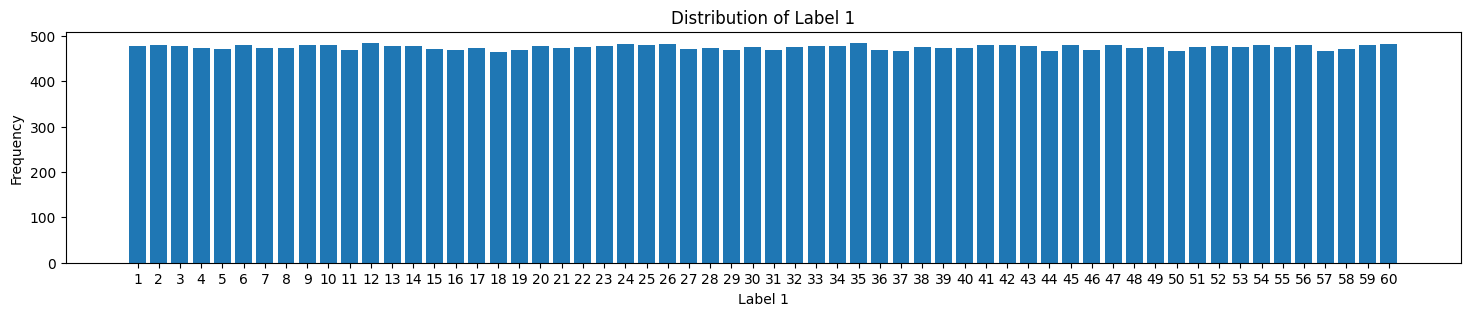

In [30]:
labels, counts = np.unique(train_label1, return_counts=True)

plt.figure(figsize=(18, 3))
plt.xticks(labels)
plt.bar(labels, counts)
plt.xlabel('Label 1')
plt.ylabel('Frequency')
plt.title('Distribution of Label 1')
plt.show()

### Feature Standardization

> Standardize the features of the dataset using **Robust scaler**

In [31]:
scaler = RobustScaler()
standardized_train_features_label1 = scaler.fit_transform(train_features_label1)
standardized_valid_features_label1 = scaler.transform(valid_features_label1)
standardized_test_features_label1 = scaler.transform(test_features_label1)

### Feature Extraction

> Principal Componenet Analysis(PCA) used to extract the features that can explain the variance of the label to 95% and display the resulting explained variances of each PC

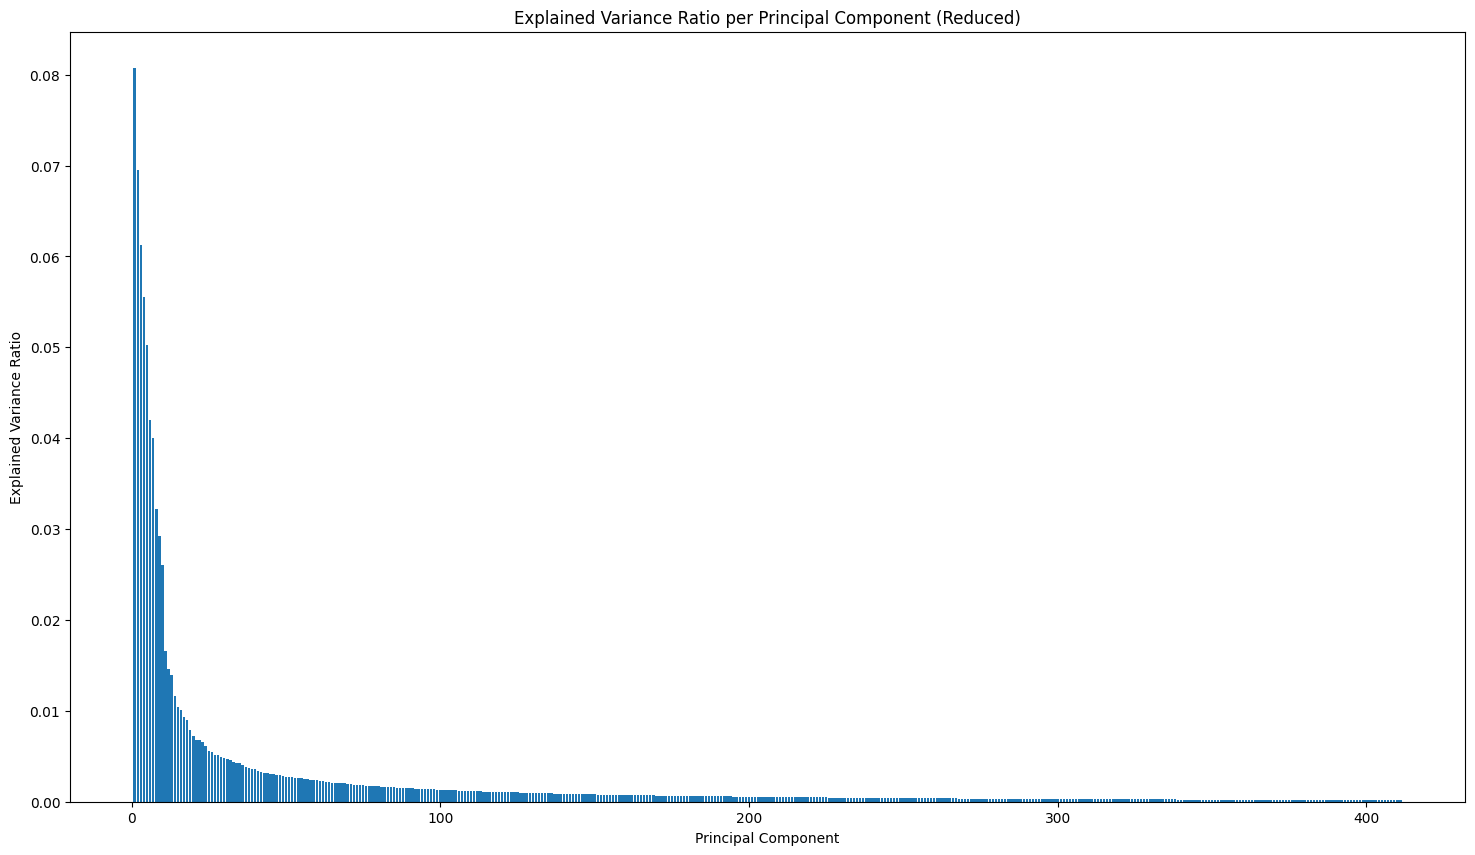


Reduced Train feature matrix shape: (28520, 411)
Reduced valid feature matrix shape: (750, 411)
Reduced test feature matrix shape: (744, 411)


In [38]:
variance_threshold = 0.97

pca = PCA(n_components=variance_threshold, svd_solver='full')

pca_train_features_label1 = pca.fit_transform(standardized_train_features_label1)
pca_valid_features_label1 = pca.transform(standardized_valid_features_label1)
pca_test_features_label1 = pca.transform(standardized_test_features_label1)

explained_variance_ratio_reduced = pca.explained_variance_ratio_

plt.figure(figsize=(18, 10))
plt.bar(range(1, pca_train_features_label1.shape[1] + 1), explained_variance_ratio_reduced)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio per Principal Component (Reduced)')
plt.show()

print("\nReduced Train feature matrix shape: {}".format(pca_train_features_label1.shape))
print("Reduced valid feature matrix shape: {}".format(pca_valid_features_label1.shape))
print("Reduced test feature matrix shape: {}".format(pca_test_features_label1.shape))

### Feature Selection

> Feature selection is typically performed in two ways: first, by checking for correlations among the features and removing highly correlated redundant features, and second, by assessing the correlations between the features and the label 01 and eliminating less related features with the label.

Get the correlation matrix of the training features

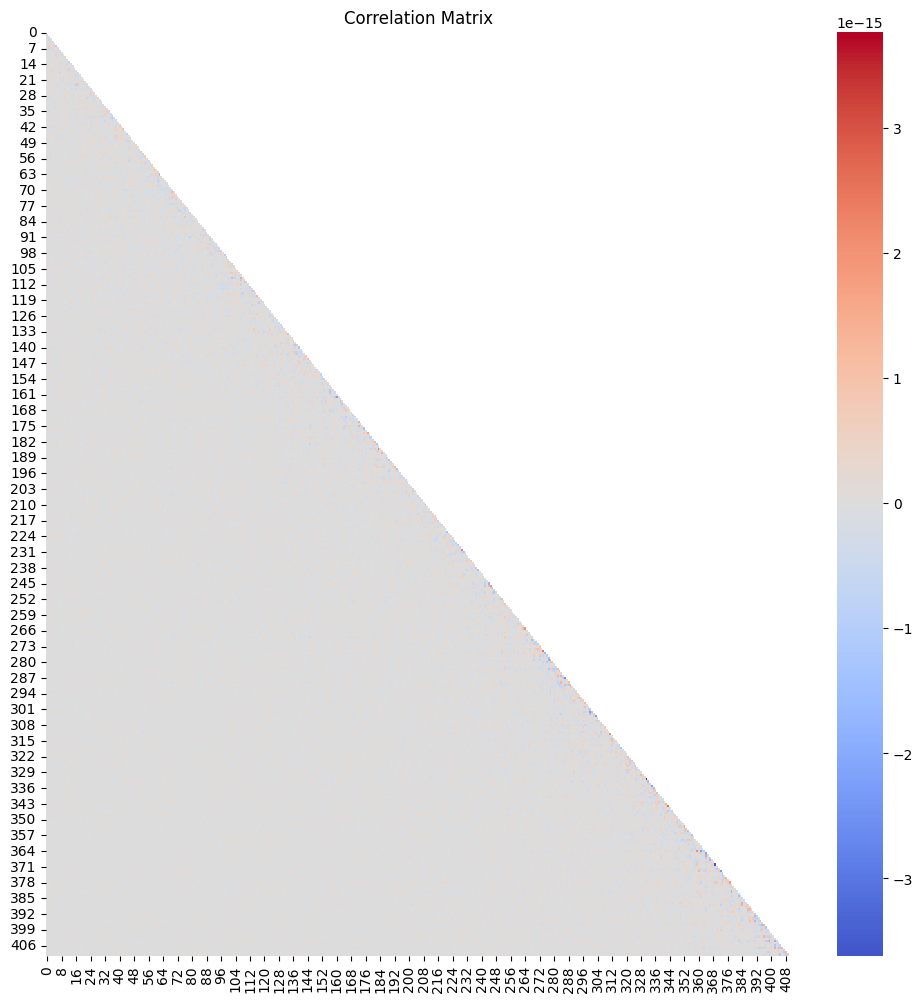

In [39]:
correlation_matrix = pd.DataFrame(pca_train_features_label1).corr()

mask = np.triu(np.ones_like(correlation_matrix))

plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, mask=mask)
plt.title("Correlation Matrix")
plt.show()

Identify the highly corellated features in the features set and remove them from the features set

In [40]:
print("Train features: {}".format(pca_train_features_label1.shape))
print("Valid features: {}".format(pca_valid_features_label1.shape))
print("Test features: {}".format(pca_test_features_label1.shape))

correlation_threshold = 0.8

highly_correlated = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated.add(colname)

print(highly_correlated)

pca_train_features_label1 = pd.DataFrame(pca_train_features_label1).drop(columns=highly_correlated)
pca_valid_features_label1 = pd.DataFrame(pca_valid_features_label1).drop(columns=highly_correlated)
pca_test_features_label1 = pd.DataFrame(pca_test_features_label1).drop(columns=highly_correlated)


print("Filtered train features: {}".format(pca_train_features_label1.shape))
print("Filtered valid features: {}".format(pca_valid_features_label1.shape))
print("Filtered test features: {}".format(pca_test_features_label1.shape))

Train features: (28520, 411)
Valid features: (750, 411)
Test features: (744, 411)
set()
Filtered train features: (28520, 411)
Filtered valid features: (750, 411)
Filtered test features: (744, 411)


Identify the highly correlated features with the label using the traning dataset and extract the features that are only highly correlated with the label

In [41]:
print("Train features: {}".format(pca_train_features_label1.shape))
print("Valid features: {}".format(pca_valid_features_label1.shape))
print("Test features: {}".format(pca_test_features_label1.shape))

correlation_with_target = pca_train_features_label1.corrwith(train_label1)

correlation_threshold = 0.005

highly_correlated_features = correlation_with_target[correlation_with_target.abs() > correlation_threshold]

print(highly_correlated_features)

pca_train_features_label1 = pca_train_features_label1[highly_correlated_features.index]
pca_valid_features_label1 = pca_valid_features_label1[highly_correlated_features.index]
pca_test_features_label1 = pca_test_features_label1[highly_correlated_features.index]

print("Filtered train features: {}".format(pca_train_features_label1.shape))
print("Filtered valid features: {}".format(pca_valid_features_label1.shape))
print("Filtered test features: {}".format(pca_test_features_label1.shape))

Train features: (28520, 411)
Valid features: (750, 411)
Test features: (744, 411)
1     -0.034271
2      0.017341
3      0.015070
4      0.033299
5      0.043794
         ...   
404    0.007384
407    0.038837
408   -0.009721
409   -0.011808
410    0.009838
Length: 338, dtype: float64
Filtered train features: (28520, 338)
Filtered valid features: (750, 338)
Filtered test features: (744, 338)


## Hyperparameter tuning

Define parameters for random search

In [42]:
svm_grid_params = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf','linear']
}

knn_grid_params = {
    'n_neighbors' : [3, 5, 7, 9, 11, 13],
    'weights' : ['uniform', 'distance'],
    'metric' : ['minkowski', 'euclidean', 'manhattan', 'hamming']
}

random_forest_grid_params = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}

Execute random search for KNN, Random forest and SVM

In [46]:
meta_data = ('SVM', SVC(), svm_grid_params)

grid_search = HalvingGridSearchCV(
    estimator=meta_data[1],
    param_grid=meta_data[2],
    cv=3,
    n_jobs=-1
)

rs_result = grid_search.fit(pca_train_features_label1, train_label1)

print(f"best score for {meta_data[0]} : {rs_result.best_score_}")
print(f"best hyper parameters for {meta_data[0]} : {rs_result.best_params_}")

# Get the best hyperparameters found by the grid search
best_params = grid_search.best_params_
print(best_params)

# # Create a new SVM object with the best hyperparameters
# best_svm = SVC(**best_params)

# # Evaluate the best SVM object on the test data
# X_test, y_test = ...
# y_pred = best_svm.predict(X_test)
# accuracy = np.mean(y_pred == y_test)

# print('Accuracy on test data:', accuracy)

best score for SVM : 0.931394948024565
best hyper parameters for SVM : {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}


In [ ]:
# Define a list of classification models
classification_models = [
    # ('K Neighbors', KNeighborsClassifier(metric='minkowski', n_neighbors=5, weights='distance')),
    # ('Random Forest', RandomForestClassifier()),
    ('SVM', SVC(C=1000, gamma=0.0001, kernel='rbf')),
]

# The best model is SVM then KNN then Random Forest

# Number of features used in PCA
num_features = pca_train_features_label1.shape[1]
print(f"Number of features: {num_features}\n")

# Train and evaluate each classification model
for model_name, model in classification_models:
    # Train the model on the training data
    model.fit(pca_train_features_label1, train_label1)

    # Predict on the train data
    y_pred_train_label1 = model.predict(pca_train_features_label1)

    # Calculate metrics for classification evaluation
    accuracy = accuracy_score(train_label1, y_pred_train_label1)
    precision = precision_score(train_label1, y_pred_train_label1, average='macro', zero_division=1)
    recall = recall_score(train_label1, y_pred_train_label1, average='macro')

    print(f"Metrics for {model_name} on train data:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print("\n")

    # Predict on the validation data
    y_pred_valid_label1 = model.predict(pca_valid_features_label1)

    # Calculate metrics for classification evaluation on validation data
    accuracy = accuracy_score(valid_label1, y_pred_valid_label1)
    precision = precision_score(valid_label1, y_pred_valid_label1, average='macro', zero_division=1)
    recall = recall_score(valid_label1, y_pred_valid_label1, average='macro')

    print(f"Metrics for {model_name} on validation data:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print("\n")

    # Predict on the test data
    y_pred_test_label1 = model.predict(pca_test_features_label1)

Number of features: 338
